# PCO2 Histogram

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [1]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

## Area

In [3]:
variables = ['areacello']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Ofx'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4']
            )


cat = col.search(**query)

dd_A = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

# combine datasets just to pick first member and it gets naming the way i want
dd_A = combine_datasets(
    dd_A,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_A.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['GFDL-ESM4.gr.historical.Ofx']

### New coords with `dd` and `dd_x`

`A` is area over Pacific and southern ocean. They get `newcoords`


In [4]:
A = dd_A['GFDL-ESM4.gr.historical.Ofx'].sel(y = slice(-80,-30)).areacello
# # A2 = dd_gr['GFDL-ESM4.gr.historical.Ofx'].areacello
# # A


# newcoords = {'x':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['x'], 'y':dd_A['GFDL-ESM4.gr.historical.Ofx'].areacello['y']}
newcoords = {'x':A['x'], 'y':A['y']}
newcoords

{'x': <xarray.DataArray 'x' (x: 360)>
 array([  0.5,   1.5,   2.5, ..., 357.5, 358.5, 359.5])
 Coordinates:
   * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
 Attributes:
     axis:           X
     bounds:         lon_bnds
     cell_methods:   time: point
     long_name:      longitude
     standard_name:  longitude
     units:          degrees_E,
 'y': <xarray.DataArray 'y' (y: 50)>
 array([-79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5, -71.5, -70.5,
        -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5, -62.5, -61.5, -60.5,
        -59.5, -58.5, -57.5, -56.5, -55.5, -54.5, -53.5, -52.5, -51.5, -50.5,
        -49.5, -48.5, -47.5, -46.5, -45.5, -44.5, -43.5, -42.5, -41.5, -40.5,
        -39.5, -38.5, -37.5, -36.5, -35.5, -34.5, -33.5, -32.5, -31.5, -30.5])
 Coordinates:
   * y        (y) float64 -79.5 -78.5 -77.5 -76.5 ... -33.5 -32.5 -31.5 -30.5
 Attributes:
     axis:           Y
     bounds:         lat_bnds
     cell_methods:   time: point


## Get datasets and calculate variables

### These datasets are selected over Pacific, southern ocean, and upper 1000m
I load them, reassign their coords to match `dd_A['GFDL-ESM4.gr.historical.Ofx']`, and then calculate `p`, `insitutemp`, `sigma2`, and `sigma0`, '`PCO2`

In [5]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0_*_20yr.nc').sel(lev = slice(0, 500), y = slice(-80,-30))
# A = xr.open_mfdataset('AREA.nc')

In [6]:
for name, ds in dd.items():
    dd[name] = ds.assign_coords(**newcoords)

In [7]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma2'] = gsw.sigma2(ds['so'],ds['thetao'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])
    ds['sigma1'] = gsw.sigma1(ds['so'],ds['thetao'])

In [8]:
for name, ds in dd.items():
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    # ds['PCO2'] = results['pCO2_out']
    # ppco2 = ds.dissic.copy(data=results['pCO2_out'])
    ds['PCO2'] = ds.dissic.copy(data=results['pCO2_out'])



In [5]:
dd['CESM2-FV2.gr.historical.Omon'].lev


<xarray.DataArray 'lev' (lev: 14)>
array([  0.,  10.,  20.,  30.,  50.,  75., 100., 125., 150., 200., 250., 300.,
       400., 500.])
Coordinates:
  * lev      (lev) float64 0.0 10.0 20.0 30.0 50.0 ... 250.0 300.0 400.0 500.0
Attributes:
    axis:           Z
    bounds:         lev_bnds
    long_name:      ocean model level
    positive:       down
    standard_name:  olevel
    units:          m

## Lev Bounds

I'm going to gloss over all of the methods here, but all this next section does is get `lev_bounds` because I didn't save those locally

In [9]:
variables = ['dissic']
#              ,'talk', 'so', 'thetao', 'fgco2']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


dd_gn = merge_variables(dd_gn)
# # list(dd_new.keys())

temp={}
for name,item in dd_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gn = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gn = combine_datasets(
    dd_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gn.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CanESM5.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [10]:
variables = ['dissic']
#              ,'talk', 'so', 'thetao', 'fgco2']
# 'areacello', 
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4',
                         'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)


temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CESM2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon']

In [11]:
dd_lev = {**dd_gr, **dd_gn}
list(dd_lev.keys())

['CESM2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [17]:
dd_lev['CESM2-FV2.gr.historical.Omon']

<xarray.Dataset>
Dimensions:        (time: 1980, lev: 33, y: 180, x: 360, bnds: 2, vertex: 4)
Coordinates:
  * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lev            (lev) float64 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time           (time) object 1850-01-15 13:00:00 ... 2014-12-15 12:00:00
    lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(33, 2), meta=np.ndarray>
    lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
    time_bounds    (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat            (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lon_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
    lat_verticies  (vertex, x, y) float64 dask.array<chunksize=(1, 360, 180), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    dissic         (time, lev, y, x) float32 dask.array<chunksize=(5, 33, 180, 360), meta=np.ndarray>
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    674885.0
    branch_time_in_parent:   10950.0
    case_id:                 1559
    ...                      ...
    variant_info:            CMIP6 CESM2-FV2 historical experiment (1850-2014...
    variant_label:           r1i1p1f1
    netcdf_tracking_ids:     hdl:21.14100/3101d2da-c304-4d9f-8b86-ead9120bfc7...
    version_id:              v20191120
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.NCAR.CESM2-FV2.historical.r1i1p1f1.Omon.dis...

In [12]:
for name, ds in dd.items():
    # dd_lev[name] = dd_lev[name].assign_coords(**newcoords)
    ds['lev_bounds'] = dd_lev[name].sel(lev = slice(0, 500), y = slice(-80,-30)).lev_bounds
    # ds['lev_bounds'] = ds['lev_bounds'].assign_coords(**newcoords)

In [14]:
ds.lev_bounds.diff('bnds').values

array([[ 2.],
       [ 3.],
       [ 3.],
       [ 4.],
       [ 6.],
       [ 8.],
       [ 9.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [15.],
       [20.],
       [20.],
       [25.],
       [30.],
       [30.],
       [35.],
       [40.],
       [40.],
       [50.]])

## Dictionary for plot colors

In [13]:
model_kwargs = {}
model_kwargs['UKESM1-0-LL.gn.historical.Omon'] = {'color': '#8f5904'}
model_kwargs['CanESM5-CanOE.gn.historical.Omon'] = {'color': '#a1a1a1'}
model_kwargs['CNRM-ESM2-1.gn.historical.Omon'] = {'color': '#cc0000'}
model_kwargs['CanESM5.gn.historical.Omon'] = {'color': '#ff8200'}
model_kwargs['IPSL-CM6A-LR.gn.historical.Omon'] = {'color': '#f1c232'}
model_kwargs['CESM2-WACCM.gr.historical.Omon'] = {'color': '#8fce00'}
model_kwargs['CESM2.gr.historical.Omon'] = {'color': '#20b2aa'}
model_kwargs['CESM2-WACCM-FV2.gr.historical.Omon'] = {'color': '#66ccff'}
model_kwargs['GFDL-ESM4.gr.historical.Omon'] = {'color': '#674ea7'}
model_kwargs['GFDL-CM4.gr.historical.Omon'] = {'color': '#800080'}
model_kwargs['MRI-ESM2-0.gr.historical.Omon'] = {'color': '#ff80ed'}
model_kwargs['CESM2-FV2.gr.historical.Omon'] = {'color': '#024c8f'}

## Volume weighted histogram for PCO2


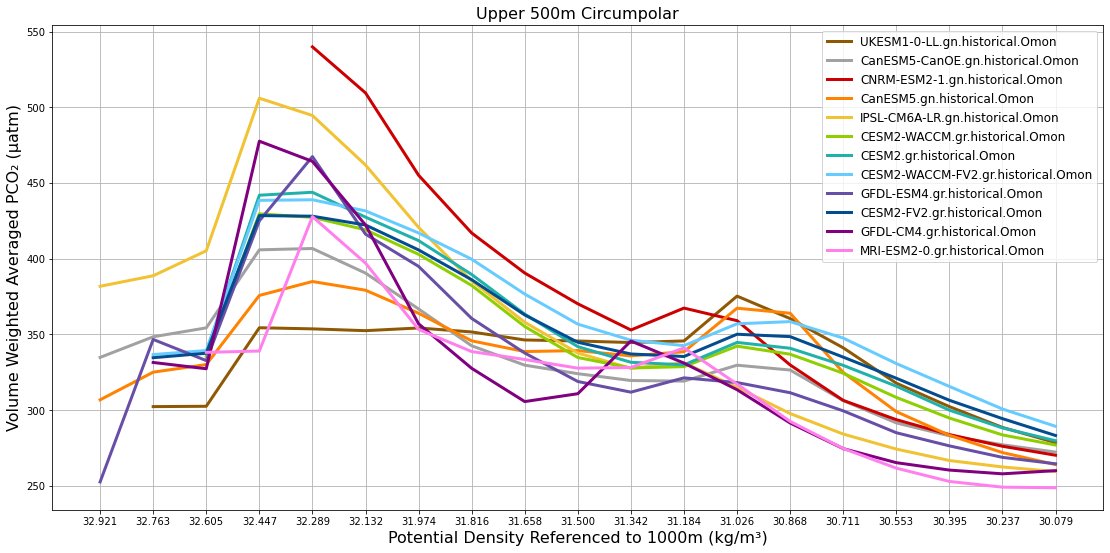

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[16,8])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=16)

target = np.linspace(30, 33, 20)
binz = np.linspace(30, 33, 20)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in dd.items():

    h2 = histogram(ds['sigma1'], bins = [binz], dim = ['y', 'x', 'lev'], weights = ds.PCO2*A*ds['lev_bounds'].diff('bnds'))
                   # *ds['lev_bounds'].diff('bnds')*A)
    h3 = histogram(ds['sigma1'], bins = [binz], dim = ['y', 'x', 'lev'], weights = A*ds['lev_bounds'].diff('bnds'))
    
    hi = h2/h3
    
    hi.plot(label = name, lw = 3, **model_kwargs[name])
    
ax.invert_xaxis()
#     ax.set_title(name)
    # ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 1000m (kg/m\u00b3)', fontsize = 16)
ax.set_ylabel('Volume Weighted Averaged PCO\u2082 (\u03BCatm)', fontsize = 16)
ax.set_title('Upper 500m Circumpolar')
ax.set_xticks([30.078947, 30.236842, 30.394737, 30.552632, 30.710526, 30.868421,
       31.026316, 31.184211, 31.342105, 31.5     , 31.657895, 31.815789,
       31.973684, 32.131579, 32.289474, 32.447368, 32.605263, 32.763158,
       32.921053])
ax.grid()
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)

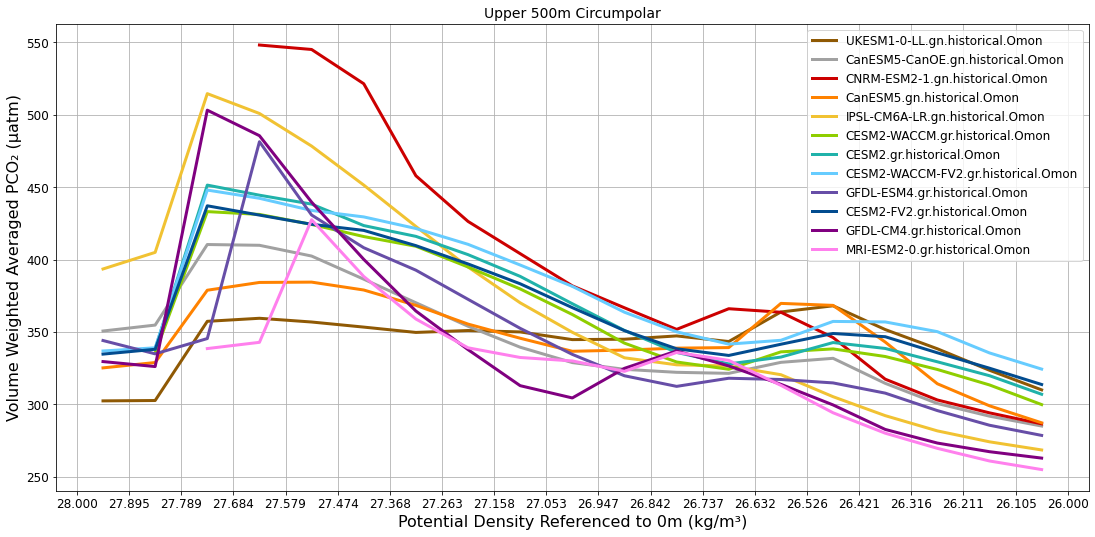

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[16,8])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 14)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=16)

target = np.linspace(26, 28, 20)
binz = np.linspace(26, 28, 20)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in dd.items():

    h2 = histogram(ds['sigma0'], bins = [binz], dim = ['y', 'x', 'lev'], weights = ds.PCO2*A*ds['lev_bounds'].diff('bnds'))
                   # *ds['lev_bounds'].diff('bnds')*A)
    h3 = histogram(ds['sigma0'], bins = [binz], dim = ['y', 'x', 'lev'], weights = A*ds['lev_bounds'].diff('bnds'))
    
    hi = h2/h3
    
    hi.plot(label = name, lw = 3, **model_kwargs[name])
    
ax.invert_xaxis()
#     ax.set_title(name)
    # ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 0m (kg/m\u00b3)', fontsize = 16)
ax.set_ylabel('Volume Weighted Averaged PCO\u2082 (\u03BCatm)', fontsize = 16)
ax.set_title('Upper 500m Circumpolar')
ax.set_xticks([26., 26.10526316, 26.21052632, 26.31578947, 26.42105263,
       26.52631579, 26.63157895, 26.73684211, 26.84210526, 26.94736842,
       27.05263158, 27.15789474, 27.26315789, 27.36842105, 27.47368421,
       27.57894737, 27.68421053, 27.78947368, 27.89473684, 28.])
ax.grid()
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)

In [22]:
target

array([26.        , 26.10526316, 26.21052632, 26.31578947, 26.42105263,
       26.52631579, 26.63157895, 26.73684211, 26.84210526, 26.94736842,
       27.05263158, 27.15789474, 27.26315789, 27.36842105, 27.47368421,
       27.57894737, 27.68421053, 27.78947368, 27.89473684, 28.        ])

/tmp/ipykernel_334/3574160726.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['y'],ds['lev'], ds['PCO2'], vmin = 300, vmax = 500)
/tmp/ipykernel_334/3574160726.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['y'],ds['lev'], ds['PCO2'], vmin = 300, vmax = 500)
/tmp/ipykernel_334/3574160726.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3

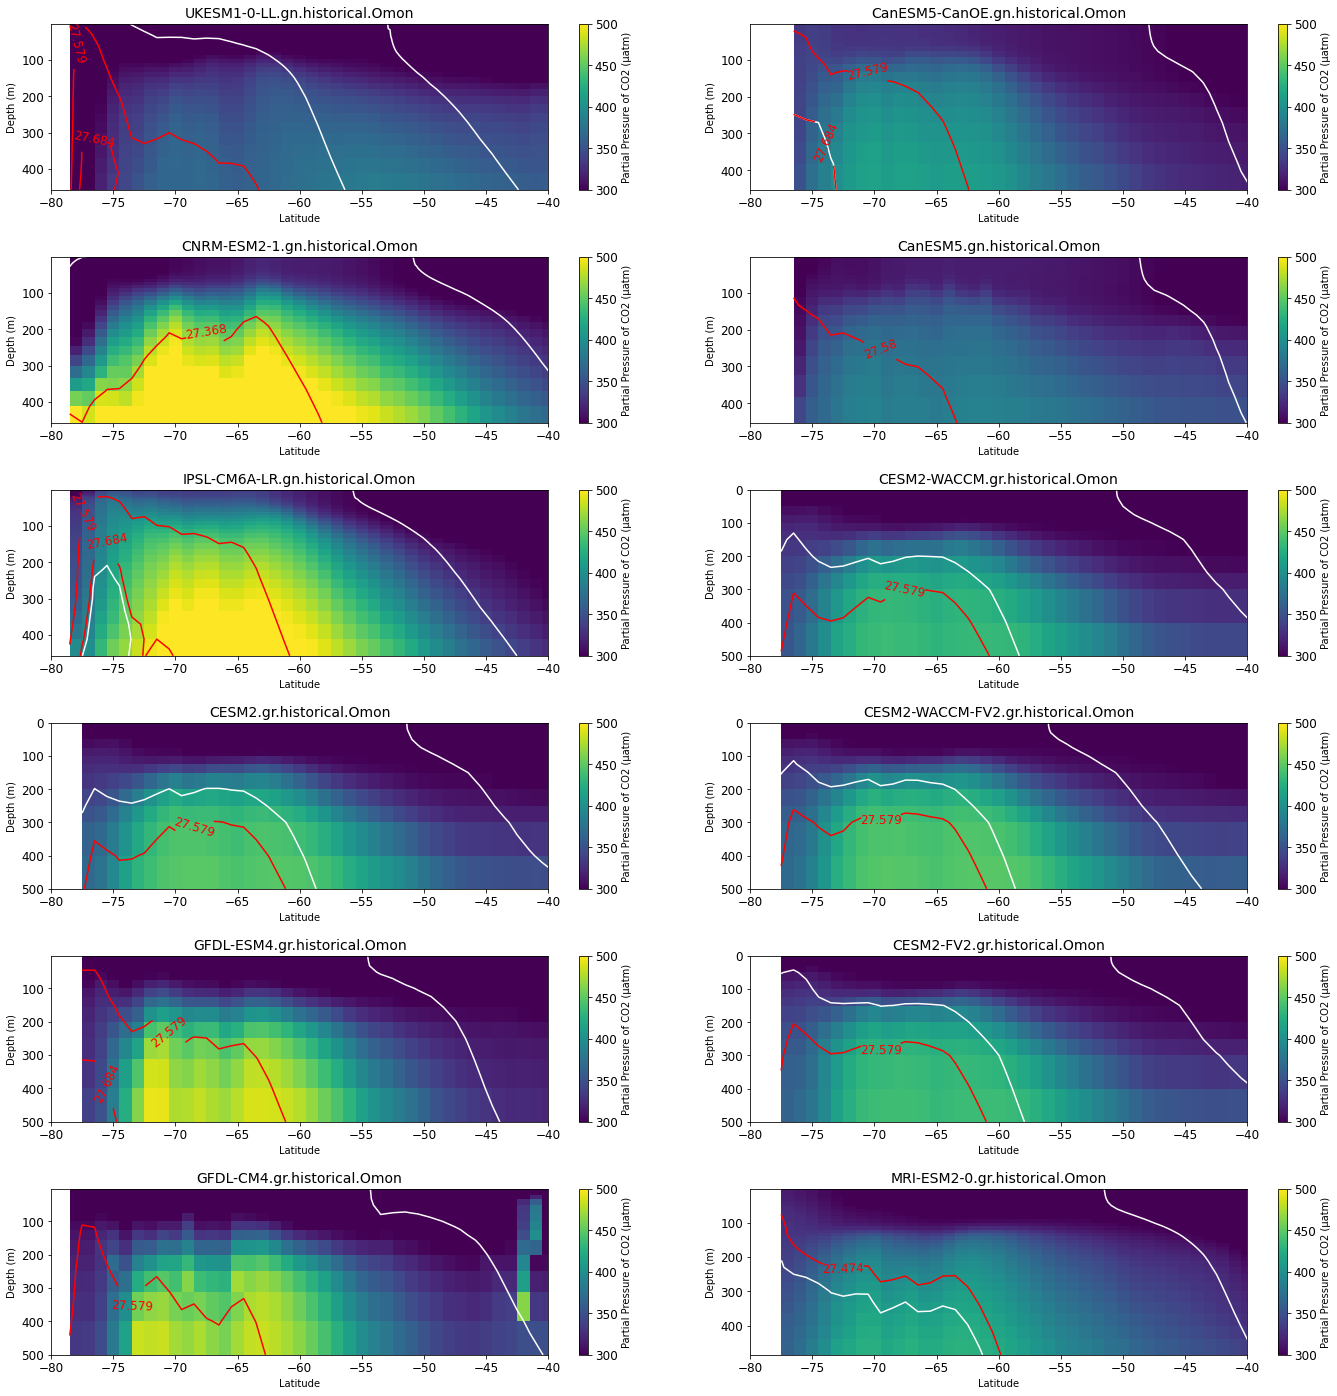

In [32]:
# This one is with sigma0 and annual mixed layer

fig, axarr = plt.subplots(nrows = 6, ncols = 2, figsize=[20,20])
fig.tight_layout(pad = 3.5)
# plt.rc('font', size = 14)
# plt.rc('axes', titlesize= 14)    
# plt.rc('axes', labelsize= 12)
# plt.rc('figure', titlesize=16)

ax_idx = 0
for name, ds in dd.items():
    ax = axarr.flat[ax_idx]
    ds = ds.mean(['x'], keep_attrs = True)
    conversion =  1e6/1035
#     results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
#                         pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
#                         temperature = ds['insitutemp'])
    ax.set_xlim([-80,-40])
    # ax.set_ylim([0,1000])
    im = ax.pcolormesh(ds['y'],ds['lev'], ds['PCO2'], vmin = 300, vmax = 500)
    if name == 'UKESM1-0-LL.gn.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.526, 27.263], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684], colors = 'r')
        
    elif name == 'CanESM5-CanOE.gn.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.684], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684, 27.789], colors = 'r')
        
    elif name == 'CNRM-ESM2-1.gn.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.684], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.447], colors = 'r')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.368, 27.579, 27.684], colors = 'r')
        
    elif name == 'CanESM5.gn.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.737], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579], colors = 'r')
        
    elif name == 'IPSL-CM6A-LR.gn.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.737, 27.7], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.763], colors = 'r')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684, 27.789], colors = 'r')
        
    elif name == 'CESM2-WACCM.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.474], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
    elif name == 'CESM2.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.474], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
    elif name == 'CESM2-WACCM-FV2.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.527, 27.474], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
    elif name == 'GFDL-ESM4.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.737, 27.737], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.605], colors = 'r')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684], colors = 'r')
        
    elif name == 'CESM2-FV2.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.316, 27.427], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
    elif name == 'GFDL-CM4.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.842, 27.842], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.605], colors = 'r')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
    elif name == 'MRI-ESM2-0.gr.historical.Omon':
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.789, 27.5], colors = 'w')
        CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.474, 27.684], colors = 'r')
    
#     if name != 'GFDL-CM4.gr.historical.Omon':
#         ax.plot(dd_mlotst[name].mlotst.y, dd_mlotst[name].mlotst.isel(x=slice(180,200), time = slice(0,239)).mean(['time', 'x'], keep_attrs=True), color = 'k', lw = 3)
# #     CS = ax.contour(ds['y'],ds['lev'],ds['sigma2'],levels=[35.5, 36, 36.5, 36.75, 37], colors = 'w')
    ax.clabel(CS, inline=1, fontsize=12, manual = False)
    cbar = plt.colorbar(im,ax=ax)
    ax.invert_yaxis()
    cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
    ax.set_title(name)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax_idx += 1

# Lets add mixed layer

In [37]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

variables = ['mlotst']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gn'],
              source_id=['IPSL-CM6A-LR', 
#                          'MPI-ESM1-2-LR', 
                         'CNRM-ESM2-1', 
                         'CanESM5', 
#                          'MPI-ESM1-2-HR', 
#                          'CMCC-ESM2', 
#                          'GISS-E2-1-G', 
                         'UKESM1-0-LL',
#                          'ACCESS-ESM1-5', 
                         'CanESM5-CanOE' 
#                          'GISS-E2-1-G-CC',
#                          'MPI-ESM-1-2-HAM'
                        ]
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gn = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gn = merge_variables(dd_gn)
# list(dd_new.keys())

temp={}
for name,item in dd_gn.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gn = temp


def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

dd_gn = combine_datasets(
    dd_gn,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gn.keys())
# dd_new_new_gn

# Regrid
targetgrid_ds = xe.util.grid_global(1.0, 1.0)
targetgrid_ds['lon'] = targetgrid_ds['lon']+180
targetgrid_ds['lon_b'] = targetgrid_ds['lon_b']+180
newcoords = {'x':targetgrid_ds['lon'][0,:],'y':targetgrid_ds['lat'][:,0]}

dd_regrid={}
for name,item in dd_gn.items():
    regridder = xe.Regridder(item, targetgrid_ds, 'bilinear', 
                         periodic=True, ignore_degenerate=True)
    ds_regridded = regridder(item['mlotst']).assign_coords(**newcoords).chunk({'time':120})
    dd_regrid[name]=ds_regridded
list(dd_regrid.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/gufunc.py:458: PerformanceWarning: Increasing number of chunks by factor of 10
  tmp = blockwise(


['IPSL-CM6A-LR.gn.historical.Omon',
 'CanESM5.gn.historical.Omon',
 'CNRM-ESM2-1.gn.historical.Omon',
 'UKESM1-0-LL.gn.historical.Omon',
 'CanESM5-CanOE.gn.historical.Omon']

In [38]:
variables = ['mlotst']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dd_gr = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)

dd_gr = merge_variables(dd_gr)

temp={}
for name,item in dd_gr.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_gr = temp
# list(dd_new_gr.keys())

dd_gr = combine_datasets(
    dd_gr,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_gr.keys())
# dd_new_new_gr


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


['CESM2.gr.historical.Omon',
 'CESM2-FV2.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon']

In [39]:
dd_mlotst = {**dd_gr, **dd_regrid}

In [40]:
# for name, ds in dd_mlotst.items():
#     ds = ds.isel(time = slice(0,239))
#     ds = ds.sel(time=ds.time.dt.season=="JJA").mean('time',keep_attrs=True)
#     dd_mlotst[name] = ds
dd_annual = {}
dd_JJA = {}
for name, ds in dd_mlotst.items():
    ds = ds.isel(time = slice(0,239))
    ds_ann = ds.mean(['time', 'x'],keep_attrs=True)
    ds_JJA = ds.sel(time=ds.time.dt.season=="JJA").mean(['time', 'x'],keep_attrs=True)
    dd_annual[name] = ds_ann
    dd_JJA[name] = ds_JJA

/tmp/ipykernel_334/199710132.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['y'],ds['lev'], ds['PCO2'], vmin = 300, vmax = 500)
/tmp/ipykernel_334/199710132.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['y'],ds['lev'], ds['PCO2'], vmin = 300, vmax = 500)
/tmp/ipykernel_334/199710132.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  

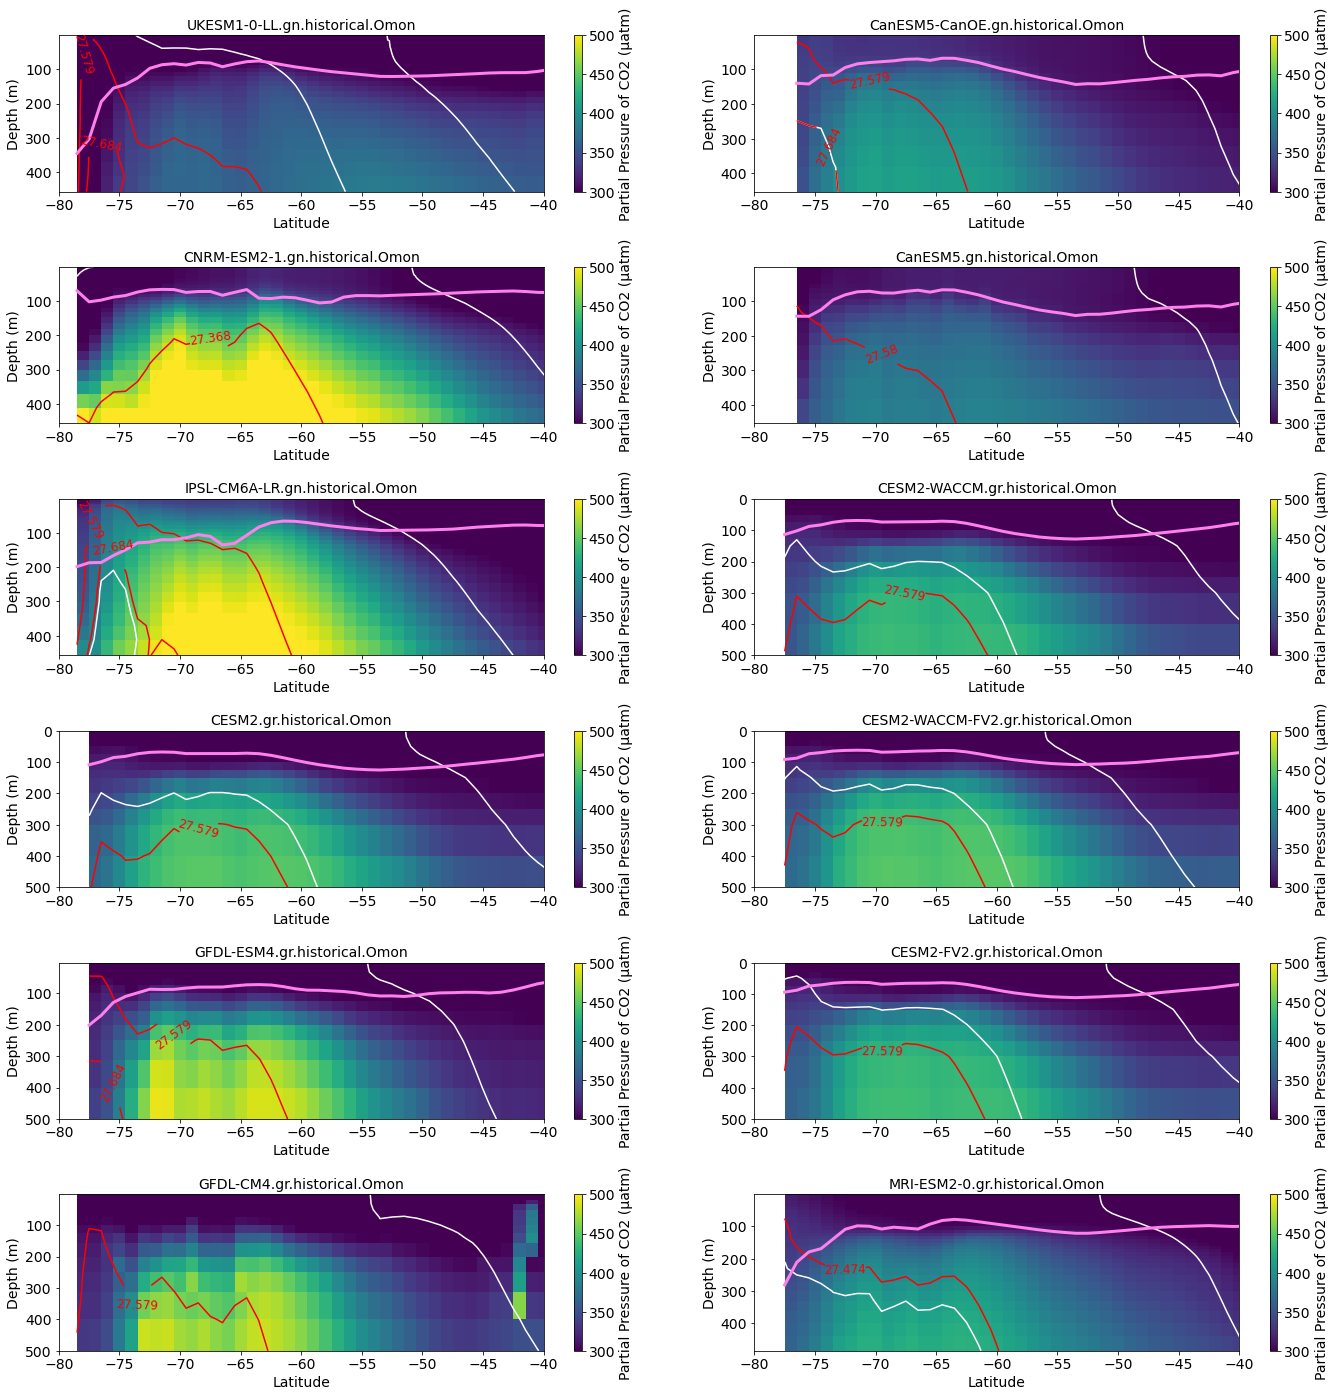

In [46]:
    # This one is with sigma0 and annual mixed layer

fig, axarr = plt.subplots(nrows = 6, ncols = 2, figsize=[20,20])
fig.tight_layout(pad = 3.5)
# plt.rc('font', size = 14)
# plt.rc('axes', titlesize= 14)    
# plt.rc('axes', labelsize= 12)
# plt.rc('figure', titlesize=16)

ax_idx = 0
for name, ds in dd.items():
    
        ax = axarr.flat[ax_idx]
        ds = ds.mean(['x'], keep_attrs = True)
        conversion =  1e6/1035
#     results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
#                         pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
#                         temperature = ds['insitutemp'])
        ax.set_xlim([-80,-40])
    # ax.set_ylim([0,1000])
        im = ax.pcolormesh(ds['y'],ds['lev'], ds['PCO2'], vmin = 300, vmax = 500)
        if name == 'UKESM1-0-LL.gn.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.526, 27.263], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684], colors = 'r')
        
        elif name == 'CanESM5-CanOE.gn.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.684], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684, 27.789], colors = 'r')
        
        elif name == 'CNRM-ESM2-1.gn.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.684], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.447], colors = 'r')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.368, 27.579, 27.684], colors = 'r')
        
        elif name == 'CanESM5.gn.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.737], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579], colors = 'r')
        
        elif name == 'IPSL-CM6A-LR.gn.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.737, 27.7], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.763], colors = 'r')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684, 27.789], colors = 'r')
        
        elif name == 'CESM2-WACCM.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.474], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
        elif name == 'CESM2.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.474], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
        elif name == 'CESM2-WACCM-FV2.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.527, 27.474], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
        elif name == 'GFDL-ESM4.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.737, 27.737], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.605], colors = 'r')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684], colors = 'r')
        
        elif name == 'CESM2-FV2.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.316, 27.427], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
        elif name == 'GFDL-CM4.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.842, 27.842], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.605], colors = 'r')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
        elif name == 'MRI-ESM2-0.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.789, 27.5], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.474, 27.684], colors = 'r')
    
#     if name != 'GFDL-CM4.gr.historical.Omon':
#         ax.plot(dd_mlotst[name].mlotst.y, dd_mlotst[name].mlotst.isel(x=slice(180,200), time = slice(0,239)).mean(['time', 'x'], keep_attrs=True), color = 'k', lw = 3)
# #     CS = ax.contour(ds['y'],ds['lev'],ds['sigma2'],levels=[35.5, 36, 36.5, 36.75, 37], colors = 'w')
    
        if name == 'CESM2-WACCM.gr.historical.Omon' or name == 'CESM2.gr.historical.Omon' or name == 'CESM2-FV2.gr.historical.Omon' or name == 'CESM2-WACCM-FV2.gr.historical.Omon' or name == 'GFDL-ESM4.gr.historical.Omon' or name == 'MRI-ESM2-0.gr.historical.Omon' :
            ax.plot(dd_annual[name].y, dd_annual[name].mlotst, color = '#ff80ed', lw = 3)
    # GFDL-CM4 doesn't have mixed layer
        elif name != 'GFDL-CM4.gr.historical.Omon':
            ax.plot(dd_annual[name].y, dd_annual[name], color = '#ff80ed', lw = 3)
    
        ax.clabel(CS, inline=1, fontsize=12, manual = False)
        cbar = plt.colorbar(im,ax=ax)
        ax.invert_yaxis()
        cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
        ax.set_title(name)
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Depth (m)')
        ax_idx += 1
    
    

/tmp/ipykernel_334/17037706.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['y'],ds['lev'], ds['PCO2'], vmin = 300, vmax = 500)
/tmp/ipykernel_334/17037706.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ds['y'],ds['lev'], ds['PCO2'], vmin = 300, vmax = 500)
/tmp/ipykernel_334/17037706.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Eit

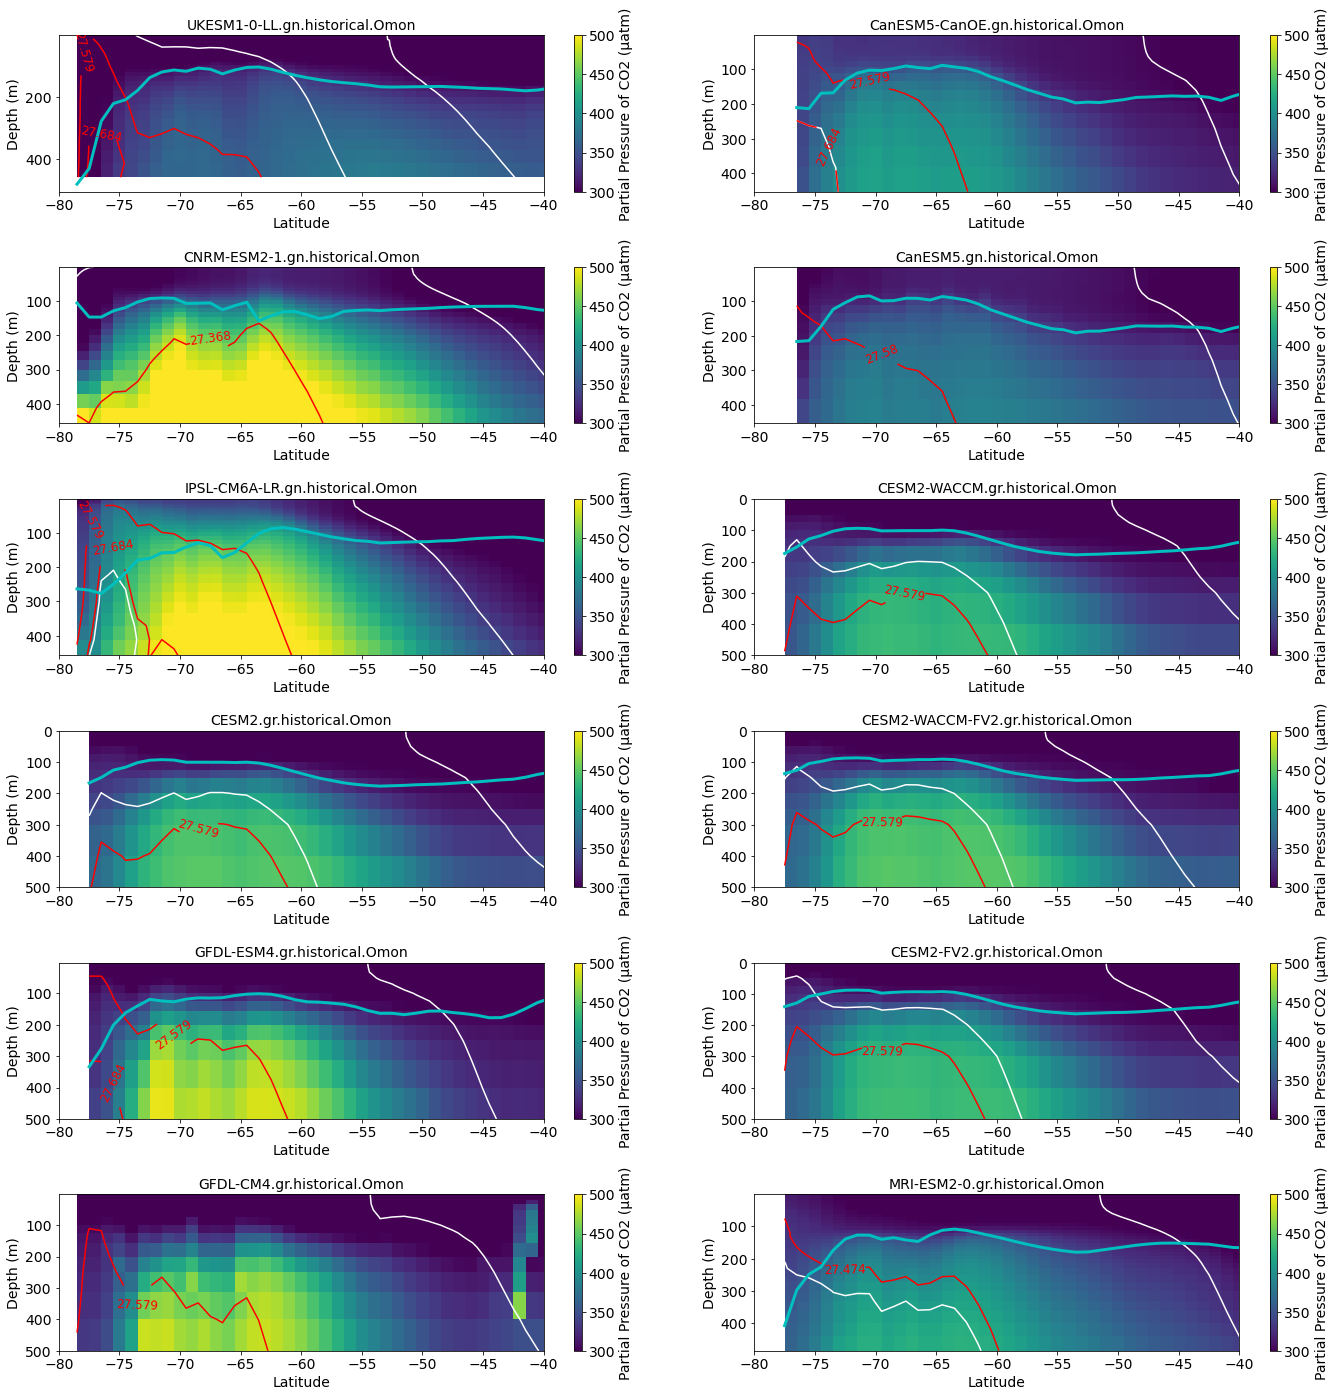

In [47]:
    # This one is with sigma0 and annual mixed layer

fig, axarr = plt.subplots(nrows = 6, ncols = 2, figsize=[20,20])
fig.tight_layout(pad = 3.5)
# plt.rc('font', size = 14)
# plt.rc('axes', titlesize= 14)    
# plt.rc('axes', labelsize= 12)
# plt.rc('figure', titlesize=16)

ax_idx = 0
for name, ds in dd.items():
    
        ax = axarr.flat[ax_idx]
        ds = ds.mean(['x'], keep_attrs = True)
        conversion =  1e6/1035
#     results = pyco2.sys(par1=ds['talk']*conversion,par2=ds['dissic']*conversion,par1_type=1,par2_type=2,
#                         pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
#                         temperature = ds['insitutemp'])
        ax.set_xlim([-80,-40])
    # ax.set_ylim([0,1000])
        im = ax.pcolormesh(ds['y'],ds['lev'], ds['PCO2'], vmin = 300, vmax = 500)
        if name == 'UKESM1-0-LL.gn.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.526, 27.263], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684], colors = 'r')
        
        elif name == 'CanESM5-CanOE.gn.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.684], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684, 27.789], colors = 'r')
        
        elif name == 'CNRM-ESM2-1.gn.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.684], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.447], colors = 'r')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.368, 27.579, 27.684], colors = 'r')
        
        elif name == 'CanESM5.gn.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.737], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579], colors = 'r')
        
        elif name == 'IPSL-CM6A-LR.gn.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.737, 27.7], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.763], colors = 'r')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684, 27.789], colors = 'r')
        
        elif name == 'CESM2-WACCM.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.474], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
        elif name == 'CESM2.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.421, 27.474], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
        elif name == 'CESM2-WACCM-FV2.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.527, 27.474], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
        elif name == 'GFDL-ESM4.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.737, 27.737], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.605], colors = 'r')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.684], colors = 'r')
        
        elif name == 'CESM2-FV2.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.316, 27.427], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
        elif name == 'GFDL-CM4.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.842, 27.842], colors = 'w')
        # CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.605], colors = 'r')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.579, 27.789], colors = 'r')
        
        elif name == 'MRI-ESM2-0.gr.historical.Omon':
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[26.789, 27.5], colors = 'w')
            CS = ax.contour(ds['y'],ds['lev'],ds['sigma0'],levels=[27.474, 27.684], colors = 'r')
    
#     if name != 'GFDL-CM4.gr.historical.Omon':
#         ax.plot(dd_mlotst[name].mlotst.y, dd_mlotst[name].mlotst.isel(x=slice(180,200), time = slice(0,239)).mean(['time', 'x'], keep_attrs=True), color = 'k', lw = 3)
# #     CS = ax.contour(ds['y'],ds['lev'],ds['sigma2'],levels=[35.5, 36, 36.5, 36.75, 37], colors = 'w')
    
        if name == 'CESM2-WACCM.gr.historical.Omon' or name == 'CESM2.gr.historical.Omon' or name == 'CESM2-FV2.gr.historical.Omon' or name == 'CESM2-WACCM-FV2.gr.historical.Omon' or name == 'GFDL-ESM4.gr.historical.Omon' or name == 'MRI-ESM2-0.gr.historical.Omon' :
            ax.plot(dd_JJA[name].y, dd_JJA[name].mlotst, color = 'c', lw = 3)
    # GFDL-CM4 doesn't have mixed layer
        elif name != 'GFDL-CM4.gr.historical.Omon':
            ax.plot(dd_JJA[name].y, dd_JJA[name], color = 'c', lw = 3)
    
        ax.clabel(CS, inline=1, fontsize=12, manual = False)
        cbar = plt.colorbar(im,ax=ax)
        ax.invert_yaxis()
        cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
        ax.set_title(name)
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Depth (m)')
        ax_idx += 1
    
    

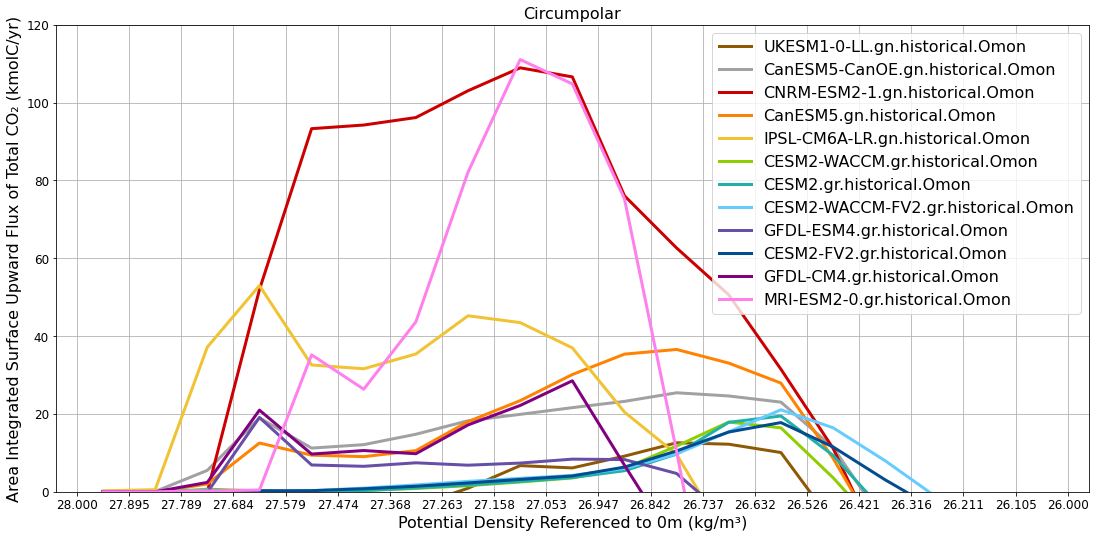

In [31]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[16,8])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 16)
plt.rc('axes', titlesize= 16)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=16)

target = np.linspace(26, 28, 20)
binz = np.linspace(26, 28, 20)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in dd.items():

    h2 = histogram(ds['sigma0'], bins = [binz], dim = ['y', 'x', 'lev'], weights = -1* ds.fgco2/1000*A)
                   # *ds['lev_bounds'].diff('bnds')*A)
    h3 = histogram(ds['sigma0'], bins = [binz], dim = ['y', 'x', 'lev'], weights = A)
    
    hi = h2/h3
    
    h2.plot(label = name, lw = 3, **model_kwargs[name])
    
ax.invert_xaxis()
#     ax.set_title(name)
    # ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 0m (kg/m\u00b3)', fontsize = 16)
ax.set_ylabel('Area Integrated Surface Upward Flux of Total CO\u2082 (kmolC/yr)', fontsize = 16)
ax.set_title('Circumpolar')
ax.set_ylim([0,120])
ax.set_xticks([26.        , 26.10526316, 26.21052632, 26.31578947, 26.42105263,
       26.52631579, 26.63157895, 26.73684211, 26.84210526, 26.94736842,
       27.05263158, 27.15789474, 27.26315789, 27.36842105, 27.47368421,
       27.57894737, 27.68421053, 27.78947368, 27.89473684, 28.        ])
ax.grid()
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right'
#     , borderaxespad=0.
)

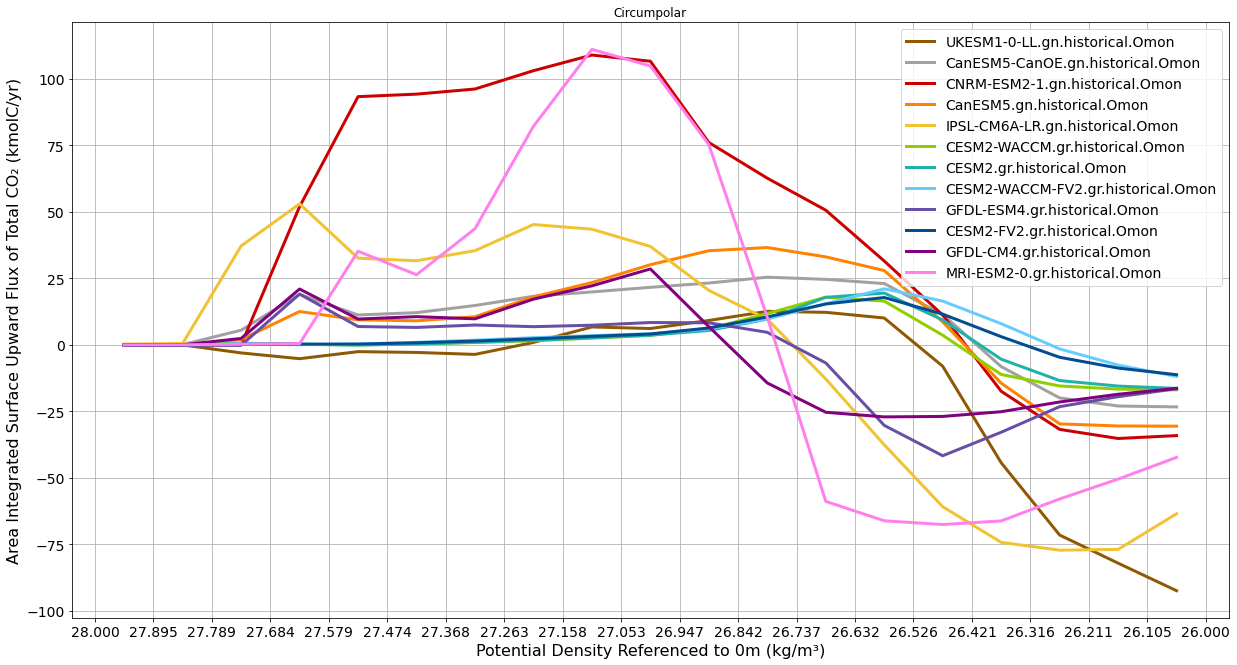

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=[18,10])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 14)
plt.rc('axes', titlesize= 12)    
plt.rc('axes', labelsize= 14)
plt.rc('figure', titlesize=14)

target = np.linspace(26, 28, 20)
binz = np.linspace(26, 28, 20)

conversion = 3.1536e7 * 83.3
ax_idx = 0
# for name, ds in dd.items():
for name, ds in dd.items():

    h2 = histogram(ds['sigma0'], bins = [binz], dim = ['y', 'x', 'lev'], weights = -1* ds.fgco2/1000*A)
                   # *ds['lev_bounds'].diff('bnds')*A)
    h3 = histogram(ds['sigma0'], bins = [binz], dim = ['y', 'x', 'lev'], weights = A)
    
    hi = h2/h3
    
    h2.plot(label = name, lw = 3, **model_kwargs[name])
    
ax.invert_xaxis()
#     ax.set_title(name)
    # ax_idx += 1
ax.set_xlabel('Potential Density Referenced to 0m (kg/m\u00b3)', fontsize = 16)
ax.set_ylabel('Area Integrated Surface Upward Flux of Total CO\u2082 (kmolC/yr)', fontsize = 16)
ax.set_title('Circumpolar')
# ax.set_ylim([0,120])
ax.set_xticks([26.        , 26.10526316, 26.21052632, 26.31578947, 26.42105263,
       26.52631579, 26.63157895, 26.73684211, 26.84210526, 26.94736842,
       27.05263158, 27.15789474, 27.26315789, 27.36842105, 27.47368421,
       27.57894737, 27.68421053, 27.78947368, 27.89473684, 28.        ])
ax.grid()
plt.legend(
#     bbox_to_anchor=(1.05, 1), 
    loc='upper right', fontsize = 14
#     , borderaxespad=0.
)

/tmp/ipykernel_334/795151709.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
/tmp/ipykernel_334/795151709.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
/tmp/ipykernel_334/795151709.py:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated sinc

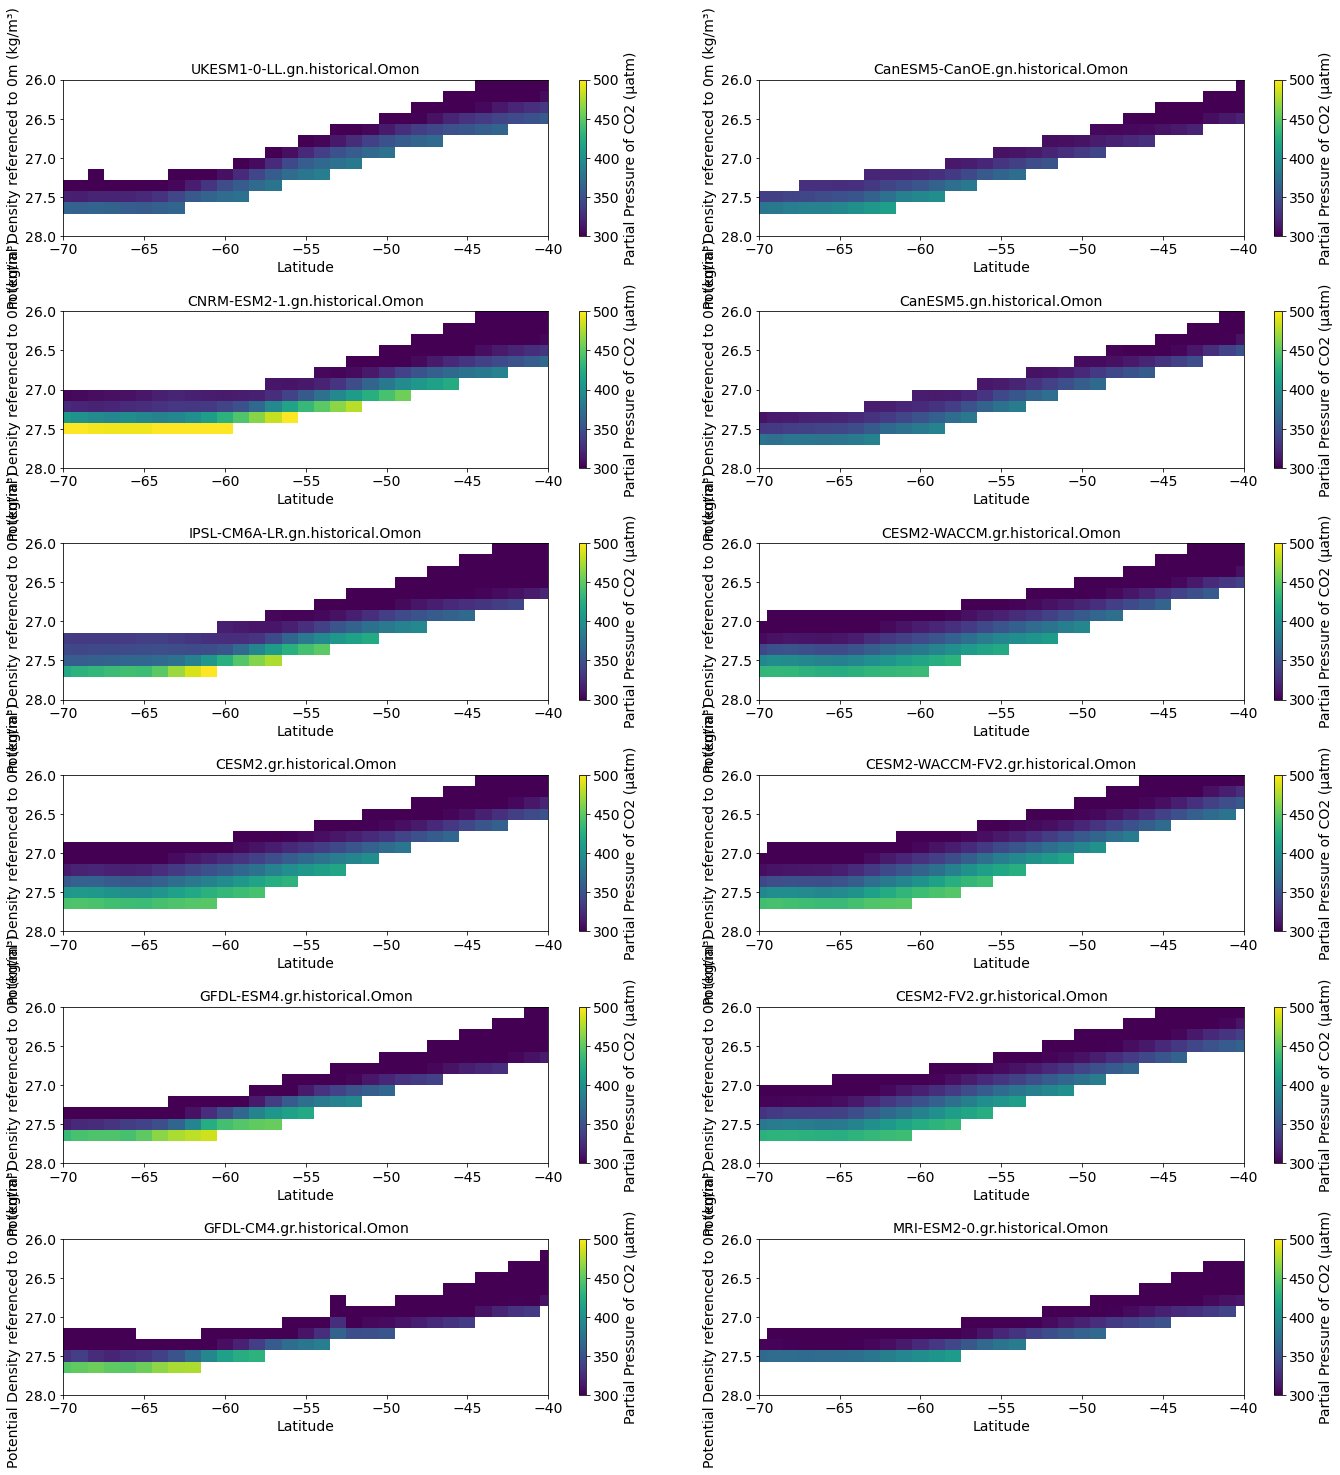

In [36]:
from xgcm import Grid

grid = Grid(ds, coords={'Z': {'center':'lev'}}, periodic=False)
target = np.linspace(35.5, 37, 35)

fig, axarr = plt.subplots(nrows = 6, ncols = 2, figsize=[20,20])
fig.tight_layout(pad = 3.5)
plt.rc('font', size = 14)
plt.rc('axes', titlesize= 14)    
plt.rc('axes', labelsize= 14)
plt.rc('figure', titlesize=16)
target_sig0 = np.linspace(26, 28, 15)
ax_idx = 0

for name, ds in dd.items():

    ax = axarr.flat[ax_idx]
    ds = ds.mean(['x'], keep_attrs = True)
    
    DIC = grid.transform(ds['dissic'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
    TALK = grid.transform(ds['talk'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
    THETAO = grid.transform(ds['thetao'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
    P = grid.transform(ds['p'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
    TEMP = grid.transform(ds['insitutemp'], 'Z', target_sig0, target_data=ds['sigma0'], method = 'linear').transpose('sigma0','y')
    conversion =  1e6/1035
    results = pyco2.sys(par1=TALK*conversion,par2=DIC*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = THETAO, pressure = P, 
                    temperature = TEMP)

    ppco2 = DIC.copy(data=results['pCO2_out'])
    ax.set_xlim([-70,-40])
    im = ax.pcolormesh(ppco2['y'],ppco2['sigma0'], ppco2, vmin = 300, vmax = 500)
    cbar = plt.colorbar(im,ax=ax)
    cbar.set_label('Partial Pressure of CO2 (\u03BCatm)')
    ax.invert_yaxis()
    ax.set_title(name)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Potential Density referenced to 0m (kg/m\u00b3)')
    ax_idx += 1